- Import Packages

In [471]:
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import math

- Load Dataset

In [472]:
# path = r"C:\Users\moaxs\Desktop\REU 2025\PDM Project\Code\Greedy Model\job_data.json"
path = "../../Input_Data/job_data.json"
with open(path, 'r') as file: 
    data = json.load(file)

- Simple Parameters

In [473]:
sample_size = 750
start_time = 0
end_time = 1400
max_length = 500

# sample_size = 8
# start_time = 0
# end_time = 9
# max_length = 1

- Greedy Jobs

In [474]:
# Take a random sample of jobs
jobs_array = data['jobs']
random.shuffle (jobs_array)

# jobs_array = [{'release': 0, 'deadline': 8, 'height': 2, 'length': 1} for _ in range(8)]

# List is same length of sample size
flexibility_array = []

i = 0
curr_index = 0
while (i < sample_size) :
    rj = jobs_array[curr_index]['release']
    dj = jobs_array[curr_index]['deadline']
    lj = jobs_array[curr_index]['length']

    fj = dj - rj - lj

    # Check if the specific job lies within the correct window
    # The funky syntax is used to put the job id at the very front of the dictionary
    if rj >= start_time and dj <= end_time and lj <= max_length:
        flexible_id = {'flexible_id': i}
        flexibility = {'flexibility': fj}
        flexible_object = {**flexible_id, **flexibility, **jobs_array[curr_index]}
        flexibility_array.append(flexible_object)

        i += 1
    
    curr_index += 1

flexible = sorted(flexibility_array, key=lambda job: job['flexibility']) 

print(flexible)
print(len(flexible))

[{'flexible_id': 541, 'flexibility': 8, 'release': 617, 'deadline': 923, 'length': 298, 'height': 330.37}, {'flexible_id': 144, 'flexibility': 13, 'release': 512, 'deadline': 884, 'length': 359, 'height': 329.72}, {'flexible_id': 458, 'flexibility': 13, 'release': 685, 'deadline': 770, 'length': 72, 'height': 458.88}, {'flexible_id': 484, 'flexibility': 14, 'release': 458, 'deadline': 717, 'length': 245, 'height': 329.9}, {'flexible_id': 226, 'flexibility': 17, 'release': 699, 'deadline': 758, 'length': 42, 'height': 743.11}, {'flexible_id': 392, 'flexibility': 18, 'release': 608, 'deadline': 670, 'length': 44, 'height': 59.65}, {'flexible_id': 224, 'flexibility': 19, 'release': 673, 'deadline': 709, 'length': 17, 'height': 883.06}, {'flexible_id': 350, 'flexibility': 19, 'release': 560, 'deadline': 627, 'length': 48, 'height': 336.5}, {'flexible_id': 225, 'flexibility': 21, 'release': 484, 'deadline': 581, 'length': 76, 'height': 383.63}, {'flexible_id': 296, 'flexibility': 21, 'relea

- Resource Curve

In [475]:
# Instantiate the resource curve
path = "../../Input_Data/solar_data.json"
with open(path, 'r') as file: 
    data = json.load(file)

wind_energy = data['series'][1]['data']
solar_energy = data['series'][2]['data']
hydro_energy = data['series'][3]['data']

# Have 165 hours and you want minute by minute resolution. Therefore the total length of this list needs to be 165 * 60 in length
# The first 60 values of the list need to equal 0, the next need to equal 1. Therefore, i // 60
wind_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(wind_energy_7_days)):
    wind_energy_7_days[i] = wind_energy[ i // 60 ]['value']

solar_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(solar_energy_7_days)):
    solar_energy_7_days[i] = solar_energy[ i // 60 ]['value']

hydro_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(hydro_energy_7_days)):
    hydro_energy_7_days[i] = hydro_energy[ i // 60 ]['value']


total = []
for i in range(165 * 60):
    total_sum = wind_energy_7_days[i] + solar_energy_7_days[i] + hydro_energy_7_days[i]
    total.append(total_sum)

day = 3
resources = total[(24 * day) + start_time : (24 * day) + end_time]

scale_factor = 4.233
resources = [r * scale_factor for r in resources]

# resources = [0, 1, 0, 2, 4, 3, 2, 1, 0]

- Find All Possible Start Times for Each Job

In [476]:
intervals = [[] for _ in range(len(flexible))]
for i, job in enumerate(flexible):
    # Extract the necessary information from the job object
    release = job['release'] - start_time
    deadline = job['deadline'] - start_time
    duration = job['length']
    num = release

    # Add the execution intervals to the sublist
    while (num + duration <= deadline):
        intervals[i].append((num, num + duration))
        num += 1

- Definitions

In [477]:
# Iterate through the jobs and add their corresponding heights
height = [job['height'] for job in flexible]

# Specify the number of time steps 
num_time_steps = end_time - start_time

- Label each job and possible interval combination

In [478]:
decision_variables = []
for j, interval_set in enumerate(intervals):
    for i, interval in enumerate(interval_set):
        # Add the decision variable and it's corresponding interval to the list
        decision_variables.append({'name' : f'x_{i}_{j}', 'value': interval})

# This is the name of the objective variable that we will minimize
objective_variable = 'd'

- Find best interval for each job

In [ ]:
final_greedy_heights = [0 for _ in range(num_time_steps)]
final_greedy_heights_2 = [0 for _ in range(num_time_steps)]
for job_id, interval_set in enumerate(intervals):
    best_score = float(math.inf)
    best_interval = None

    best_score_2 = float(-math.inf)
    best_interval_2 = None

    job_height = flexible[job_id]['height']

    for interval in interval_set:
        interval_start, interval_end = interval[0], interval[1]

        # this is measuring the total area oabove the curve
        # If this sum is greater than 0, that means that there is an amount of area above the curve
        score = sum([(final_greedy_heights[i] + job_height) - resources[i] for i in range(interval_start, interval_end)])

        # We want to find the max of this array above
        # because we are more concerned right now with PDAC
        score_2 = max([resources[i] - final_greedy_heights_2[i] - job_height for i in range(interval_start, interval_end)])

        if score < best_score:
            best_score = score
            best_interval = interval

        if score_2 > best_score_2:
            best_score_2 = score_2
            best_interval_2 = interval
    
    for i in range(best_interval[0], best_interval[1]):
        final_greedy_heights[i] += job_height
    
    for i in range(best_interval_2[0], best_interval_2[1]):
        final_greedy_heights_2[i] += job_height 


In [480]:
max_objective_value = 0
for i, height in enumerate(final_greedy_heights):
    max_objective_value = max(max_objective_value, height - resources[i])

min_objective_value = 0
for i, height in enumerate(final_greedy_heights_2):
    min_objective_value = max(min_objective_value, height - resources[i])

print(f"AAC objective val: {max_objective_value}, PDAC objective val: {min_objective_value}")

AAC objective val: 8388.585, PDAC objective val: 11340.416999999976


- Final Heights for Each Job Interval

- Plot jobs

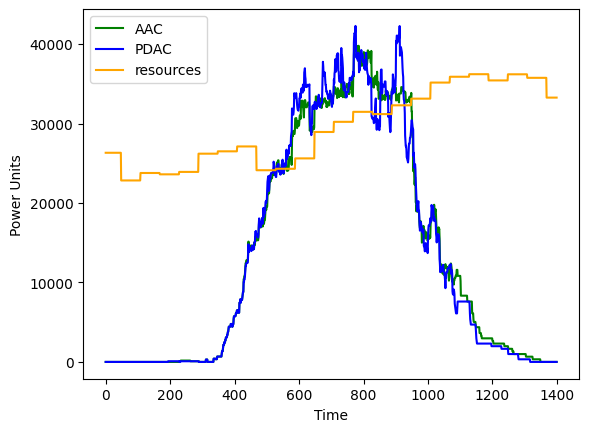

In [481]:
job_graph_xvalues = np.array([i for i in range(start_time, end_time)])

plt.plot(job_graph_xvalues, final_greedy_heights, label="AAC", color='green')
plt.plot(job_graph_xvalues, final_greedy_heights_2, label="PDAC", color='blue')
plt.plot(job_graph_xvalues, resources, label='resources', color='orange')

plt.xlabel("Time")
plt.ylabel("Power Units")
plt.legend()
plt.show()